# GARNET for Jet-Images 
## 

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
data_dir = '/Users/sznajder/cernbox/WorkM1/tensorflow_macos/arm64/workdir/data/hls4ml_LHCjet_150p_val/'

# Load train and test JetID datasets as numpy arrays 

In [1]:
import numpy as np
import h5py
import os
from einops import rearrange, reduce, repeat


#Data PATH
DATA_PATH = '/Users/sznajder/WorkM1/workdir/data/'

nconstit = 32

X_train_val = np.load("../../data/X_train_val_nconst_{}.npy".format(nconstit))
X_test = np.load("../../data/X_test_nconst_{}.npy".format(nconstit))
Y_train_val = np.load("../../data/Y_train_val_nconst_{}.npy".format(nconstit))
Y_test = np.load("../../data/Y_test_nconst_{}.npy".format(nconstit))

print("Loaded X_train_val ----> shape:", X_train_val.shape)
print("Loaded X_test      ----> shape:", X_test.shape)
print("Loaded Y_train_val ----> shape:", X_train_val.shape)
print("Loaded Y_test      ----> shape:", X_test.shape)

nfeat = X_train_val.shape[-1]


Loaded X_train_val ----> shape: (589600, 32, 3)
Loaded X_test      ----> shape: (290400, 32, 3)
Loaded Y_train_val ----> shape: (589600, 32, 3)
Loaded Y_test      ----> shape: (290400, 32, 3)


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



## GARNET implementation from  Thea

In [6]:
#from garnet import *
from tensorflow.keras import metrics, Model
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import tensorflow.keras as keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, BatchNormalization, Flatten
# Thea's version of GARNET
from garnet_hls4ml_compat import *


K = keras.backend

#vmax = nconstit
vmax = 8

#'''
# Garnet layers for 32 constituents
n_aggregators = 20
n_filters     = 5
n_propagate   = 5
n_dense       = 25
#'''

'''
# Garnet layers for 16 constituents
n_aggregators = 20
n_filters     = 9
n_propagate   = 5
n_dense       = 28
'''

'''
# Garnet layers for 8 constituents
n_aggregators = 20
n_filters     = 10
n_propagate   = 10
n_dense       =32
'''

###############################################################

# Garnet Model

x = Input(shape=(nconstit, nfeat), name="inpx")
n = Input(shape=(1,), dtype='uint16', name="inpn")
vmax = nconstit
inp = [x, n]

xx = BatchNormalization(name='batchnorm')(inp[0])
nn = inp[1]

v = GarNet(n_aggregators, n_filters, n_propagate, simplified=True, input_format='xn',
           output_activation=None, name='gar_1', quantize_transforms=False, 
           kernel_quant='', bias_quant='')([xx,nn])

#################################################################


v = Flatten()(v)
v = Activation('relu', name='relu0')(v)
#v = Flatten()(v)


v = Dense(n_dense, name='dense1')(v)
v = Activation('relu',name='relu1')(v)


out = Dense(5, name='dense_out')(v)
out = Activation('softmax',name='softmx')(out)

###############################################################

# Build the model
model = Model(inputs=inp, outputs=out)

# Compile the model
optim = Adam(learning_rate=0.0002)
model.compile(optimizer=optim, loss='categorical_crossentropy',metrics=['categorical_accuracy'])

# print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inpx (InputLayer)               [(None, 32, 3)]      0                                            
__________________________________________________________________________________________________
batchnorm (BatchNormalization)  (None, 32, 3)        12          inpx[0][0]                       
__________________________________________________________________________________________________
inpn (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
gar_1 (GarNet)                  (None, 32, 5)        605         batchnorm[0][0]                  
                                                                 inpn[0][0]                   

## Run training
Here, we run the training.

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,TerminateOnNaN 

# early stopping callback
est = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
lrs = ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=5)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
model_checkpoint = ModelCheckpoint('Garnet_arpita.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   save_freq=1)

# Train classifier
V_train_val =  np.ones((X_train_val.shape[0],1))*vmax
history = model.fit( [ X_train_val, V_train_val ] , Y_train_val, 
                    epochs=150, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[lrs , est, TerminateOnNaN()], 
                    validation_split=0.33 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 

# Set model and output name
arch = 'Garnet'
fname = arch+'_nconst_'+str(nmax)
print('Saving Model : ',fname)


# Save the model
model.save('model_'+fname+'.h5')

## Save the model weights in a separate file
model.save_weights('weights_'+fname+'.h5')

Epoch 1/150
772/772 [==============================] - 9s 11ms/step - loss: 1.3900 - categorical_accuracy: 0.3909 - val_loss: 1.2638 - val_categorical_accuracy: 0.4684
Epoch 2/150
772/772 [==============================] - 10s 12ms/step - loss: 1.1786 - categorical_accuracy: 0.5226 - val_loss: 1.1186 - val_categorical_accuracy: 0.5591
Epoch 3/150
772/772 [==============================] - 10s 13ms/step - loss: 1.0832 - categorical_accuracy: 0.5752 - val_loss: 1.0589 - val_categorical_accuracy: 0.5887
Epoch 4/150
772/772 [==============================] - 11s 14ms/step - loss: 1.0367 - categorical_accuracy: 0.5985 - val_loss: 1.0175 - val_categorical_accuracy: 0.6088
Epoch 5/150
772/772 [==============================] - 11s 14ms/step - loss: 0.9952 - categorical_accuracy: 0.6195 - val_loss: 0.9763 - val_categorical_accuracy: 0.6300
Epoch 6/150
772/772 [==============================] - 11s 14ms/step - loss: 0.9606 - categorical_accuracy: 0.6369 - val_loss: 0.9454 - val_categorical_accu

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

(array([0., 1.]), array([231937,  58463]))
(array([0., 1.]), array([233896,  56504]))
(array([0., 1.]), array([232073,  58327]))
(array([0., 1.]), array([232063,  58337]))
(array([0., 1.]), array([231631,  58769]))


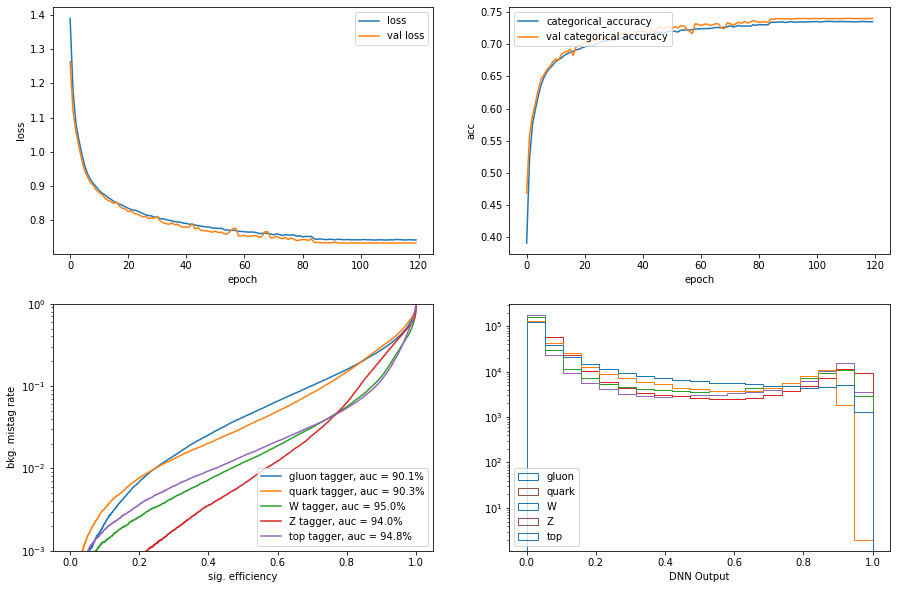

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
precision = {}
recall = {}
NN = {}
NP = {}
TP = {}
FP = {}
TN = {}
FN = {}
tresholds = {}


ax = plt.subplot(2, 2, 3)

# Get the model predictions
V_test =  np.ones((X_test.shape[0],1))*vmax
Y_predict = model.predict([X_test,V_test])


# Loop over classes(labels) to get metrics per class
for i, label in enumerate(labels):
    fpr[label], tpr[label], tresholds[label] = roc_curve(Y_test[:,i], Y_predict[:,i])
#    precision[label], recall[label], tresholds = precision_recall_curve(Y_test[:,i], Y_predict[:,i]) 
    print( np.unique(Y_test[:,i], return_counts=True) )
    _ , N = np.unique(Y_test[:,i], return_counts=True) # count the NEGATIVES and POSITIVES samples in your test set
    NN[label] = N[0]                   # number of NEGATIVES 
    NP[label] = N[1]                   # number of POSITIVES
    TP[label] = tpr[label]*NP[label]
    FP[label] = fpr[label]*NN[label] 
    TN[label] = NN[label] - FP[label]
    FN[label] = NP[label] - TP[label]

    auc1[label] = auc(fpr[label], tpr[label])
    ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))


ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')

# Display plots
fig = plt.gcf()
plt.show()




In [9]:
from sklearn.metrics import accuracy_score

# Save plots
fig.savefig(fname+'.pdf')


# Save FPR for a given TPR value ( 30% , 50% & 80%)
with open('FPR@TPR_'+fname+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( arch+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
               
               
# Save ROC AUC for each label
with open('ROCAUC_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+'\n'
  file.write(header)
  rocauc = str(auc1[labels[0]])+', '+str(auc1[labels[1]])+', '+str(auc1[labels[2]])+', '+str(auc1[labels[3]])+', '+str(auc1[labels[4]])
  file.write(rocauc)


# Save NN Accuracy for treshold of 0.5 for each label and the average over all classes
acc_avg = float(accuracy_score (np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1)))
with open('ACCURACY_'+fname+'.csv', 'w') as file:
  header = labels[0]+', '+labels[1]+', '+labels[2]+', '+labels[3]+', '+labels[4]+', '+'acc_avg'+'\n'
  file.write(header)
  accuracy = ''
  for label in labels:  
    idx = np.argmax( tresholds[label] <= 0.5 )
    accuracy += str( (TP[label][idx]+TN[label][idx])/(NP[label]+NN[label]) )+', '
  accuracy += str(acc_avg) 
  file.write(accuracy)
  




Label =  gluon  with treshold =  0.3
TPR =  0.3000872346612387
FPR =  0.014240936116272954
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000085524177685
FPR =  0.04191655492655333
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000102629013222
FPR =  0.15884054721756338
 
Label =  quark  with treshold =  0.3
TPR =  0.3000141582896786
FPR =  0.013091288435886035
 
Label =  quark  with treshold =  0.5
TPR =  0.5000176978620983
FPR =  0.03116342305982146
 
Label =  quark  with treshold =  0.8
TPR =  0.8000318561517769
FPR =  0.14850189827957724
 
Label =  W  with treshold =  0.3
TPR =  0.30008400912099026
FPR =  0.004464112585264119
 
Label =  W  with treshold =  0.5
TPR =  0.5000257170778541
FPR =  0.011785084865537998
 
Label =  W  with treshold =  0.8
TPR =  0.8000411473245667
FPR =  0.05612027250046322
 
Label =  Z  with treshold =  0.3
TPR =  0.30030683785590623
FPR =  0.0017839983108035317
 
Label =  Z  with treshold =  0.5
TPR =  0.5002142722457446
FPR =  0.006386196851716991
 

In [10]:
# Test Loading Garnet model
from tensorflow.keras.models import load_model
'''
# Delete the model and clear session
try:
    del model
    tf.keras.backend.clear_session()
except:
  print("Model not defined")    

model = load_model( 'model_'+fname+'.h5' , custom_objects={"GarNet":GarNet, "QDense":QDense, "QActivation":QActivation,
                                                           "quantized_bits":quantized_bits} )
model.summary()
'''




'\n# Delete the model and clear session\ntry:\n    del model\n    tf.keras.backend.clear_session()\nexcept:\n  print("Model not defined")    \n\nmodel = load_model( \'model_\'+fname+\'.h5\' , custom_objects={"GarNet":GarNet, "QDense":QDense, "QActivation":QActivation,\n                                                           "quantized_bits":quantized_bits} )\nmodel.summary()\n'

In [11]:
from sklearn.metrics import accuracy_score

# Save a sample of events for Thea test on HLS

njets=3000
print(X_test.shape)
np.save('x_test_8const.npy', X_test[0:njets,:])
np.save('y_test_8const.npy', Y_test[0:njets,:])

'''
print(X_test.shape)
np.save('x_test_8const_full.npy', X_test)
np.save('y_test_8const_full.npy', Y_test)
'''

# Keras average accuracy to compare with 
y_keras = model.predict([X_test[0:njets,:],V_test[0:njets,:]])
accuracy_keras  = float(accuracy_score (np.argmax(Y_test[0:njets,:],axis=1), np.argmax(y_keras,axis=1)))
print("accuracy_keras = ",accuracy_keras)




(290400, 32, 3)
accuracy_keras =  0.7463333333333333


In [12]:

'''
## Save the model weights in a separate file
model.load_weights('weights_'+fname+'.h5')


# Keras average accuracy to compare with 
y_keras = model.predict([X_test[0:njets,:],V_test[0:njets,:]])
accuracy_keras  = float(accuracy_score (np.argmax(Y_test[0:njets,:],axis=1), np.argmax(y_keras,axis=1)))
print("accuracy_keras = ",accuracy_keras)

# Save the model
model.save('model_'+fname+'.h5')
'''



'\n## Save the model weights in a separate file\nmodel.load_weights(\'weights_\'+fname+\'.h5\')\n\n\n# Keras average accuracy to compare with \ny_keras = model.predict([X_test[0:njets,:],V_test[0:njets,:]])\naccuracy_keras  = float(accuracy_score (np.argmax(Y_test[0:njets,:],axis=1), np.argmax(y_keras,axis=1)))\nprint("accuracy_keras = ",accuracy_keras)\n\n# Save the model\nmodel.save(\'model_\'+fname+\'.h5\')\n'